In [1]:
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
from nltk.corpus import stopwords

import os #For looking through files
import os.path #For managing file paths
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
news_df1 = pd.read_pickle('../news_df_norm1.pkl')

In [3]:
news_df2 = pd.read_pickle('../news_df_norm2.pkl')

In [4]:
news_df = pd.concat([news_df1, news_df2])

In [5]:
our_stops = lucem_illud.stop_words_basic

def prepare_dataframe(dataframe, text_column):
    dataframe['tokenized_sents'] = dataframe[text_column].apply(
        lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
    dataframe['normalized_sents'] = dataframe['tokenized_sents'].apply(
        lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = our_stops, stemmer = None) for s in x])

def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [6]:
#prepare df
prepare_dataframe(news_df, 'text')
news_w2v = gensim.models.word2vec.Word2Vec(news_df['normalized_sents'].sum())

In [33]:
#words to create dimensions
# news_target_words = ['arab', 'china', 'india', 'america', 'uk', 'australia', 'nigeria', 'kenya']
news_target_words = []
news_target_words += ['rich', 'developed', 'wealth','wealthy', 'developing', 'poor','poverty','low']
news_target_words += ['solution', 'hope', 'action', 'goal', 'risk', 'fear', 'disaster', 'failure']
news_target_words += ['research', 'report', 'science', 'scientist', 'hoax', 'alternative', 'doubt', 'skeptic']
news_target_words += ['agreement', 'government', 'international', 'nation', 'resource','energy','sustainable','invest']

In [34]:
def wordDimension(news_w2v, news_target_words):
    wordsSubMatrix = []
    for word in news_target_words:
        wordsSubMatrix.append(news_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)

    news_pca_words = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    news_reduced_pca = news_pca_words.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    news_tsne_words = sklearn.manifold.TSNE(n_components = 2).fit_transform(news_reduced_pca)

    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(news_tsne_words[:, 0], news_tsne_words[:, 1], alpha = 0) #Making the points invisible
    for i, word in enumerate(news_target_words):
        ax.annotate(word, (news_tsne_words[:, 0][i],news_tsne_words[:, 1][i]), size =  20 * (len(news_target_words) - i) / len(news_target_words))
    plt.xticks(())
    plt.yticks(())
    plt.show()

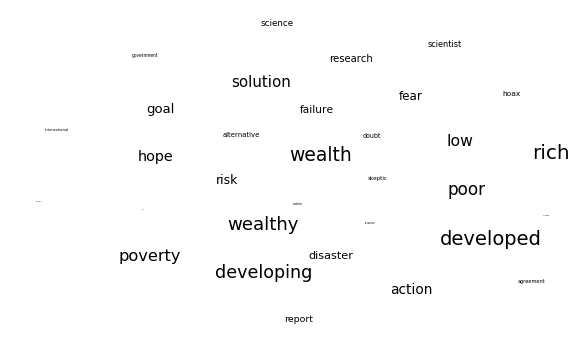

In [35]:
wordDimension(news_w2v, news_target_words)

In [16]:
def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def makeDF2(model, to_classify_list, dim_name_list, dims):
    dict_to_build ={}
    for i in range(len(dim_name_list)):
        sims = []
        for word in to_classify_list:
            sims.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dims[i].reshape(1,-1))[0][0])
        dict_to_build[dim_name_list[i]] = sims
    df = pd.DataFrame(dict_to_build, index = to_classify_list)
    return df

In [21]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [30]:
dim_wealth = dimension(news_w2v, ['rich', 'developed', 'wealth','wealthy'], ['developing', 'poor','poverty','low'])
dim_outlook = dimension(news_w2v, ['solution', 'hope', 'action', 'goal'],['risk', 'fear', 'disaster', 'failure'])
dim_science = dimension(news_w2v, ['research', 'report', 'science', 'scientist'], ['hoax', 'alternative', 'doubt', 'skeptic'])
dim_poli_eco = dimension(news_w2v, ['agreement', 'government', 'international', 'nation'], ['resource','energy','sustainable','invest'])
dim_countries = ['arab', 'china', 'india', 'america', 'uk', 'australia', 'nigeria', 'kenya']

In [36]:
country_df = makeDF2(news_w2v, dim_countries, ['wealthy','hopeful','believing','political'], [dim_wealth, dim_outlook, dim_science, dim_poli_eco])

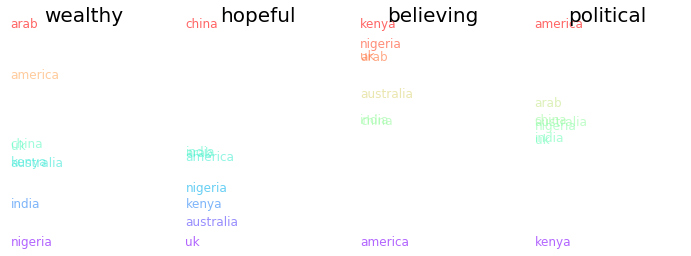

In [37]:
#plot it 
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(141)
PlotDimension(ax1, country_df, 'wealthy')
ax2 = fig.add_subplot(142)
PlotDimension(ax2, country_df, 'hopeful')
ax3 = fig.add_subplot(143)
PlotDimension(ax3, country_df, 'believing')
ax4 = fig.add_subplot(144)
PlotDimension(ax4, country_df, 'political')
plt.show()